In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# silence warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [3]:
! ../../../keras-retinanet/keras_retinanet/bin/train.py --weights ../../../resnet50_coco_best_v2.1.0.h5 \
--batch-size 2 --steps 500 --epochs 20 \
--snapshot-path ../Data/image-level-split/snapshots \
--random-transform \
--config ../Data/image-level-split/elephant-config-image-level-no-other.ini \
csv ../Data/image-level-split/train/annotations_final_no.csv ../Data/elephant_classes_no.csv \
--val-annotations ../Data/image-level-split/valid/annotations_final_no.csv

Using TensorFlow backend.
Creating model, this may take a second...
Model: "retinanet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (Activation)         (None, None, None, 6 0           bn_conv1[0][0]                   
______________________

In [4]:
! ../../../keras-retinanet/keras_retinanet/bin/train.py --weights ../Data/image-level-split/snapshots/resnet50_csv_12.h5 \
--batch-size 2 --steps 500 --epochs 8 \
--snapshot-path ../Data/image-level-split/snapshots_no \
--random-transform \
--config ../Data/image-level-split/elephant-config-image-level-no-other.ini \
csv ../Data/image-level-split/train/annotations_final_no.csv ../Data/elephant_classes_no.csv \
--val-annotations ../Data/image-level-split/valid/annotations_final_no.csv

Using TensorFlow backend.
Creating model, this may take a second...
Model: "retinanet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (Activation)         (None, None, None, 6 0           bn_conv1[0][0]                   
______________________

In [8]:
# convert the model weights to a usable format
! ../../../keras-retinanet/keras_retinanet/bin/convert_model.py --config ../Data/image-level-split/elephant-config-image-level.ini  ../Data/image-level-split/snapshots/resnet50_csv_11.h5 ../Data/image-level-split/model_no_11_epochs.h5
# run the model on test set
! ../../../keras-retinanet/keras_retinanet/bin/evaluate.py csv ../Data/image-level-split/test/annotations_final_no.csv ../Data/elephant_classes_no.csv ../Data/image-level-split/model_no_11_epochs.h5

Using TensorFlow backend.
Using TensorFlow backend.
Loading model, this may take a second...
Running network: 100% (406 of 406) |#####| Elapsed Time: 0:04:29 Time:  0:04:29
Parsing annotations: 100% (406 of 406) |#| Elapsed Time: 0:00:00 Time:  0:00:00
106 instances of class bull with average precision: 0.6741
634 instances of class cow with average precision: 0.8135
1863 instances of class pup with average precision: 0.6241
Inference time for 406 images: 0.6481
mAP using the weighted average of precisions among classes: 0.6723
mAP: 0.7039


In [5]:
%matplotlib inline

%reload_ext autoreload
%autoreload 2

import keras

from keras_retinanet.models import retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
import json
from random import shuffle

import tensorflow as tf

def get_session():
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.compat.v1.Session(config=config)

tf.compat.v1.keras.backend.set_session(get_session())

Using TensorFlow backend.


In [6]:
model_path = '../Data/image-level-split/model_18_epochs.h5'

print(model_path)

model = models.load_model(model_path, backbone_name='resnet50')

#print(model.summary())

labels_to_names = {0: 'bull', 1: 'cow', 2: 'pup', 3: 'other'}

../Data/image-level-split/model_18_epochs.h5


In [7]:
image_dir = "../Data/image-level-split/test/"

image_list = []
for root, dirs, files in os.walk(image_dir):
    for filename in files:
        if filename.lower().endswith(('.jpg')):
            image_list.append(image_dir + filename)

print(len(image_list))

408


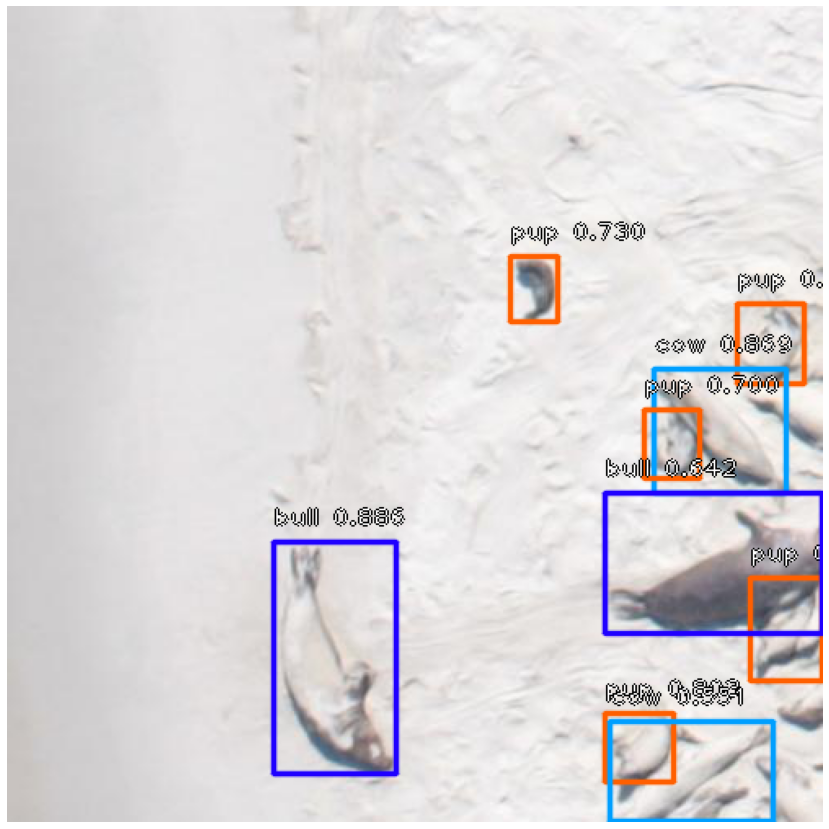

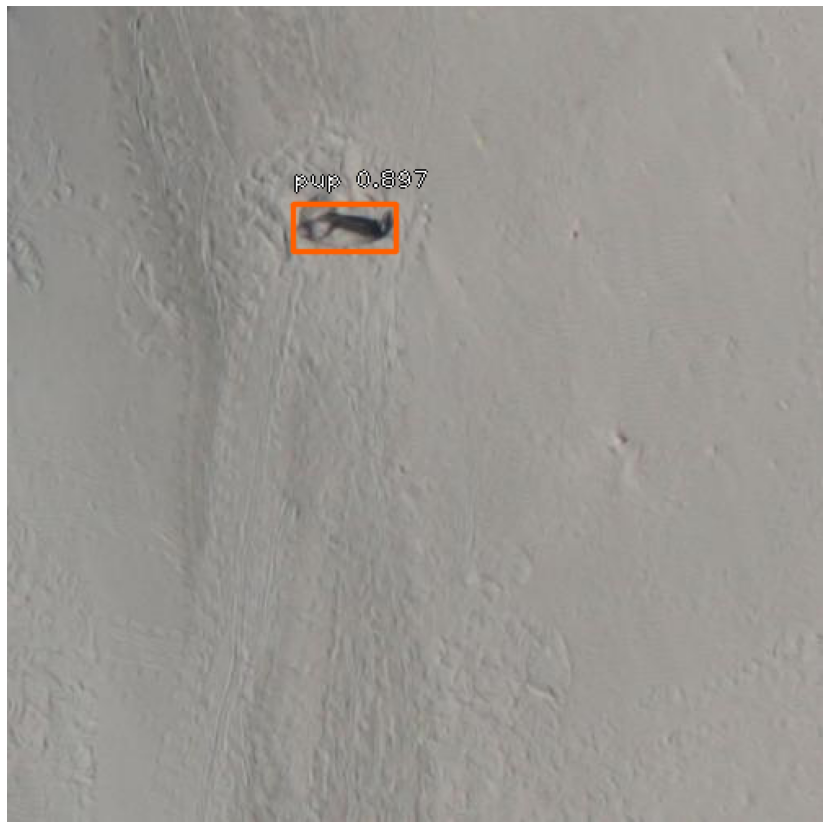

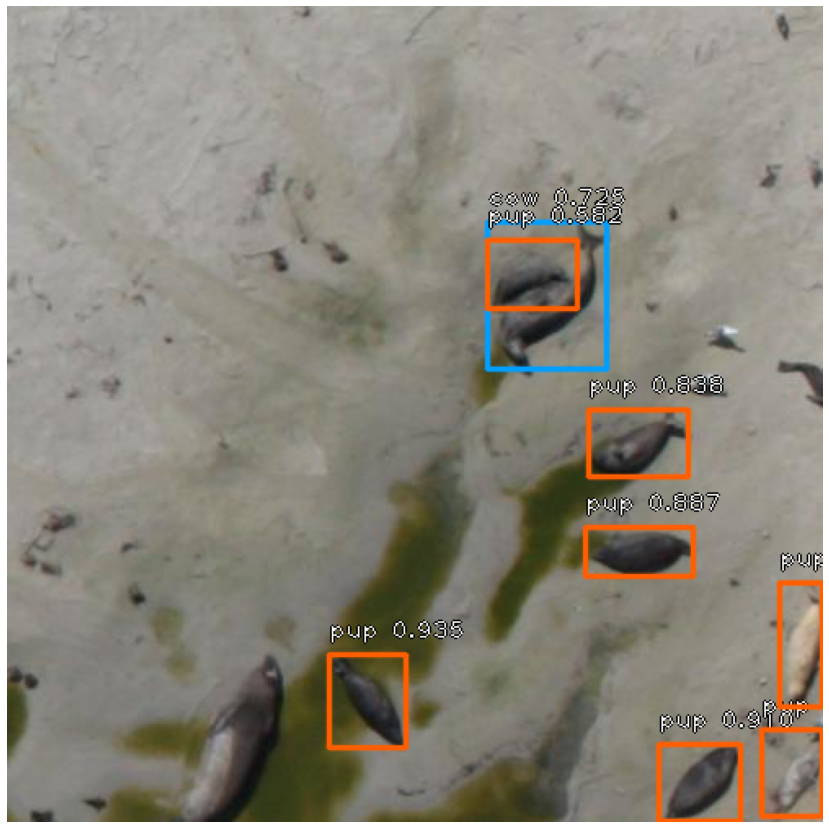

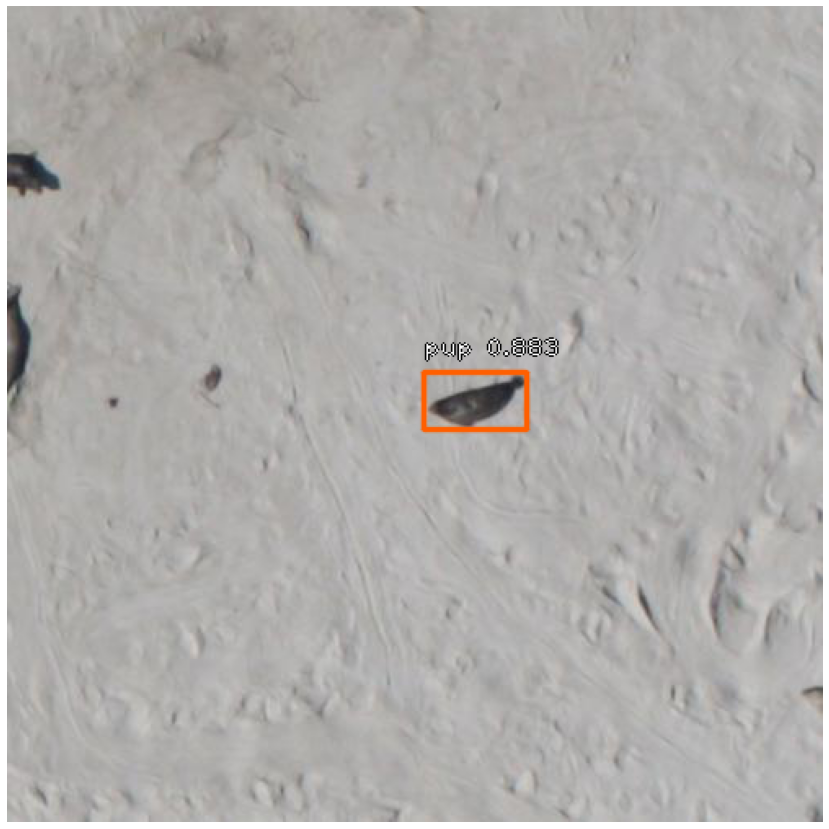

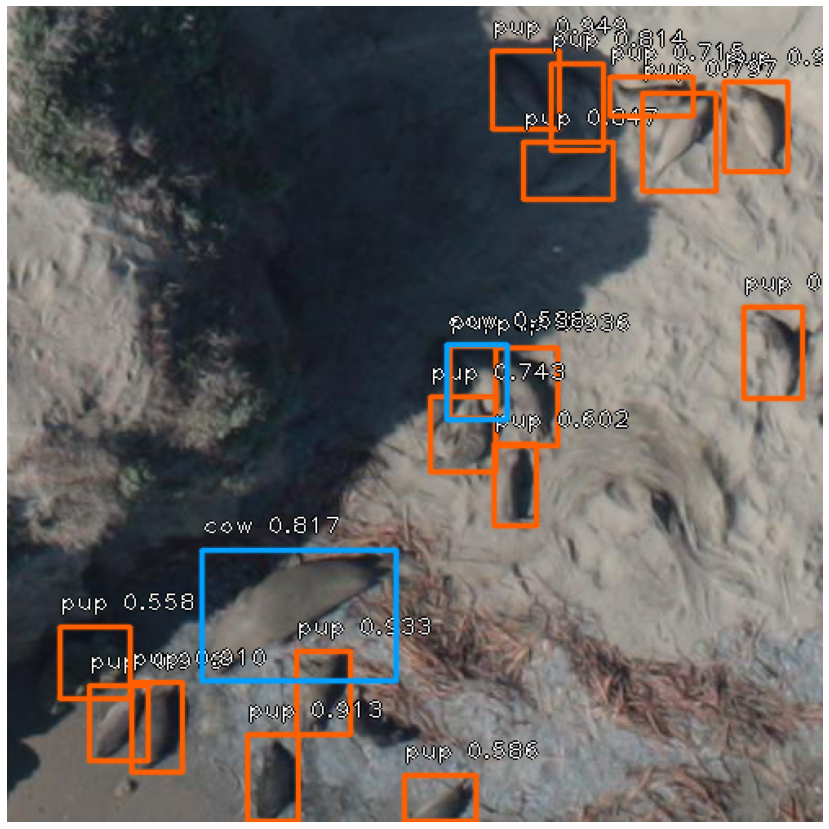

In [ ]:
visualize = True
min_score = 0.5

detections = {}

total_time = 0

count = 0
detection_iterations = 10
shuffle(image_list)

for image_path in image_list: 
    if count > detection_iterations:
        break
    else: 
        count +=1
    
    image = read_image_bgr(image_path)
    
    if visualize:
        draw = image.copy()
        draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
        
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    total_time += time.time() - start 
    
    boxes /= scale
    if any(score >= min_score for score in scores [0]):
        detections[image_path] = []
    
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < min_score:
            break
        
        b = box.astype(int)
        detections[image_path].append({"box" : b, "label" : label, "score" : score})
        
        if visualize: 
            color = label_color(label)
            
            draw_box(draw, b, color=color)
            
            caption = "{} {:.3f}".format(labels_to_names[label], score)
            draw_caption(draw, b, caption)
            
    if any(score >= min_score for score in scores[0]):
        if visualize:
            plt.figure(figsize=(15, 15))
            plt.axis('off')
            plt.imshow(draw)
            plt.show()
            
print("Finished, time per image:", total_time/len(image_list))

In [8]:
min_score = 0.5

detections = {}

total_time = 0

for image_path in image_list:
    
    image = read_image_bgr(image_path)
          
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    total_time += time.time() - start
    
    boxes /= scale  
        
    if any(score >= min_score for score in scores[0]):
        detections[image_path] = []
        
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < min_score:
            break
        
        b = box.astype(int)    
        detections[image_path].append({"box" : b, "label" : label, "score" : score})
        
            
print("Finished, time per image:", total_time/len(image_list))

Finished, time per image: 0.5264812006669886


In [9]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [10]:
with open('../Data/image-level-split/test_detections.json', 'w') as fp:
    json.dump(detections, fp, cls=MyEncoder)